In [ ]:
!pip install tensorflow opencv-python matplotlib gdown

### **Importing Important Library**

In [ ]:
import tensorflow as tf
import os
import urllib
import zipfile
import shutil
import gdown
import zipfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

### **Preventing OOM**

In [ ]:
# This code intend to avoid OOM(Out Of Memory)Errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

### **Downloading Dataset**

In [ ]:
# Function to download dataset from gdrive
def download_and_extract_data():
    url = 'https://drive.google.com/uc?id=18VLuTtzVG7-r_GixJf0uEFLXGSOvA5mn'  # URL to the file
    output = 'Dataset.zip'  # file name to-be downloaded

    gdown.download(url, output, quiet=False)

    with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
        zip_ref.extractall()

In [ ]:
# Running the dataset-download function
download_and_extract_data()

Downloading...
From: https://drive.google.com/uc?id=18VLuTtzVG7-r_GixJf0uEFLXGSOvA5mn
To: /content/Dataset.zip
100%|██████████| 234M/234M [00:03<00:00, 74.4MB/s]


In [ ]:
# Count the number of images in each folder
def count_images_in_folder(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
            count += 1
    return count

defect_path = 'Dataset/defect'
good_path = 'Dataset/good'

defect_count = count_images_in_folder(defect_path)
good_count = count_images_in_folder(good_path)

print(f"Number of images in the 'defect' folder: {defect_count}")
print(f"Number of images in the 'good' folder: {good_count}")

Number of images in the 'defect' folder: 1723
Number of images in the 'good' folder: 1695


### **Splitting the Data**

In [ ]:
# Path to the extracted dataset folder
dataset_path = '/content/Dataset'

# Path to training and validation folder
train_dir = '/content/dataset_to_use/training'
validation_dir = '/content/dataset_to_use/validation'

# Define paths for classes 'defect' and 'good'
defect_path = os.path.join(dataset_path, 'defect')
good_path = os.path.join(dataset_path, 'good')

# Create training and validation folders for each class
train_defect_dir = os.path.join(train_dir, 'defect')
train_good_dir = os.path.join(train_dir, 'good')
validation_defect_dir = os.path.join(validation_dir, 'defect')
validation_good_dir = os.path.join(validation_dir, 'good')

os.makedirs(train_defect_dir, exist_ok=True)
os.makedirs(train_good_dir, exist_ok=True)
os.makedirs(validation_defect_dir, exist_ok=True)
os.makedirs(validation_good_dir, exist_ok=True)

# Get list of files for class 'defect' and 'good'
defect_files = os.listdir(defect_path)
good_files = os.listdir(good_path)

In [ ]:
# Split the dataset into training and validation (e.g., 80-20)
train_defect_files, val_defect_files = train_test_split(defect_files, test_size=0.2, random_state=42)
train_good_files, val_good_files = train_test_split(good_files, test_size=0.2, random_state=42)

# Move files into the training and validation folders
for file in train_defect_files:
    shutil.copy(os.path.join(defect_path, file), os.path.join(train_defect_dir, file))
for file in val_defect_files:
    shutil.copy(os.path.join(defect_path, file), os.path.join(validation_defect_dir, file))

for file in train_good_files:
    shutil.copy(os.path.join(good_path, file), os.path.join(train_good_dir, file))
for file in val_good_files:
    shutil.copy(os.path.join(good_path, file), os.path.join(validation_good_dir, file))

# Check the number of images in each class for training and validation
print(f"Number of defect images for training: {len(os.listdir(train_defect_dir))}")
print(f"Number of good images for training: {len(os.listdir(train_good_dir))}")
print(f"Number of defect images for validation: {len(os.listdir(validation_defect_dir))}")
print(f"Number of good images for validation: {len(os.listdir(validation_good_dir))}")

Number of defect images for training: 1378
Number of good images for training: 1356
Number of defect images for validation: 345
Number of good images for validation: 339


### **Data Augmentation**

In [ ]:
# Applying Data Augmentation for The Data
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_dir = '/content/dataset_to_use/training'
validation_dir = '/content/dataset_to_use/validation'


# Applying Data Augmentation for Training Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    # batch_size=32,
    class_mode='binary')  # Using class_mode='binary' for binary classification

# Applying Data Augmentation for Validation Data
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    # batch_size=32,
    class_mode='binary')  # Also using class_mode='binary' for binary classification

Found 2734 images belonging to 2 classes.
Found 684 images belonging to 2 classes.


### **Building the Model**

In [ ]:
# # Version 1
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# Version 2
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 8)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 73, 73, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 18496)             0

### **Compile and Train the Model**

In [ ]:
EPOCHS = 100

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    # steps_per_epoch=20,
    epochs=EPOCHS,
    validation_data=validation_generator,
    # validation_steps=5,
    verbose=2
    )

Epoch 1/100
86/86 - 90s - loss: 0.9396 - accuracy: 0.5026 - val_loss: 0.6922 - val_accuracy: 0.5614 - 90s/epoch - 1s/step
Epoch 2/100
86/86 - 98s - loss: 0.6954 - accuracy: 0.5523 - val_loss: 0.6815 - val_accuracy: 0.4956 - 98s/epoch - 1s/step
Epoch 3/100
86/86 - 99s - loss: 0.6745 - accuracy: 0.5940 - val_loss: 0.6562 - val_accuracy: 0.6637 - 99s/epoch - 1s/step
Epoch 4/100
86/86 - 89s - loss: 0.6190 - accuracy: 0.6624 - val_loss: 0.5897 - val_accuracy: 0.7032 - 89s/epoch - 1s/step
Epoch 5/100
86/86 - 92s - loss: 0.6134 - accuracy: 0.6584 - val_loss: 0.6071 - val_accuracy: 0.6944 - 92s/epoch - 1s/step
Epoch 6/100
86/86 - 95s - loss: 0.5816 - accuracy: 0.6942 - val_loss: 0.5330 - val_accuracy: 0.7485 - 95s/epoch - 1s/step
Epoch 7/100
86/86 - 94s - loss: 0.5645 - accuracy: 0.7089 - val_loss: 0.6337 - val_accuracy: 0.6345 - 94s/epoch - 1s/step
Epoch 8/100
86/86 - 99s - loss: 0.5392 - accuracy: 0.7180 - val_loss: 0.5895 - val_accuracy: 0.6886 - 99s/epoch - 1s/step
Epoch 9/100
86/86 - 91s 

### **Try Predicting Using the Model**

In [ ]:
import numpy as np

uploaded = files.upload()

def map_class(prediction):
    if prediction < 0.5:
        return 'defect'
    else:
        return 'good'

for fn in uploaded.keys():
    # Predicting images
    path = fn
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    class_label = map_class(classes[0][0])
    print(fn)
    print(class_label)

Saving try18.jpg to try18.jpg
1/1 [==============================] - 0s 25ms/step
try18.jpg
defect


### **Visualizing Training and Validation Accuracy**

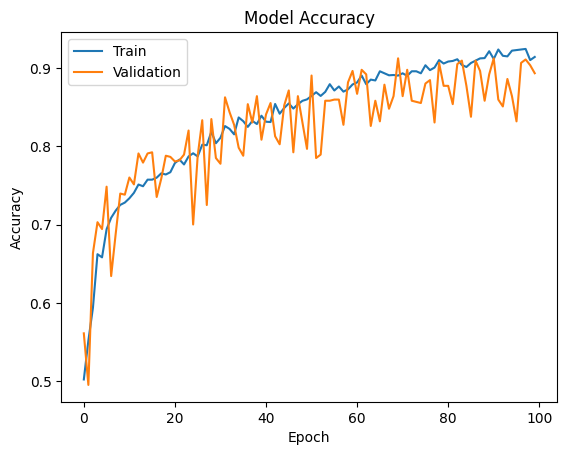

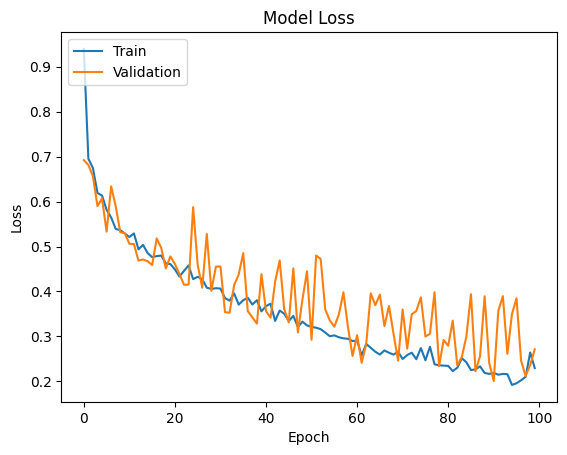

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values (optional)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Showing the best epoch with the best training accuracy and the best validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

best_epoch = 1  # Initialize best epoch
best_acc = 0.0  # Initialize best accuracy

for epoch in range(len(train_acc)):
    if train_acc[epoch] > best_acc and val_acc[epoch] > best_acc:
        best_acc = max(train_acc[epoch], val_acc[epoch])
        best_epoch = epoch + 1

print(f"Best Epoch: {best_epoch}")
print(f"Best Training Accuracy: {train_acc[best_epoch - 1]}")
print(f"Best Validation Accuracy: {val_acc[best_epoch - 1]}")


Best Epoch: 91
Best Training Accuracy: 0.9114850163459778
Best Validation Accuracy: 0.9122806787490845


### **Save Model to H5 and Tflite**

In [ ]:
# Save the model into H5
from tensorflow.keras.models import save_model

model.save('GBCG_v2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('GBCG_v2.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

with open('GBCG_v2.tflite', 'wb') as f:
    f.write(tflite_model)